In [5]:
### ----- IMPORT LIBRARIES ----- ###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

plt.style.use('../../Paul_style.txt')
#plt.rcParams["font.family"] = "Serif"

In [6]:
planet_names = ['HD189-DOGRAY',
                #'HD189-DOGRAY-ALL-CLOUDS'
                #'HD189-DOGRAY-ALL-CLOUDS-COMPACT',
                #'HD189-DOGRAY-NUC-CLOUDS',
                #'HD189-DOGRAY-NUC-CLOUDS-COMPACT',
                'HD189-PICKET']
                #'HD189-PICKET-ALL-CLOUDS',
                #'HD189-PICKET-ALL-CLOUDS-COMPACT',
                #'HD189-PICKET-NUC-CLOUDS',
                #'HD189-PICKET-NUC-CLOUDS-COMPACT',
                #'HD209-DOGRAY',
                #'HD209-DOGRAY-ALL-CLOUDS',
                #'HD209-DOGRAY-ALL-CLOUDS-COMPACT',
                #'HD209-DOGRAY-NUC-CLOUDS',
                #'HD209-DOGRAY-NUC-CLOUDS-COMPACT',
                #'HD209-PICKET',
                #'HD209-PICKET-ALL-CLOUDS',
                #'HD209-PICKET-ALL-CLOUDS-COMPACT',
                #'HD209-PICKET-NUC-CLOUDS',
                #'HD209-PICKET-NUC-CLOUDS-COMPACT']
base = '../Spectral-Processing/GCM-OUTPUT/'

In [7]:
column_names = ['lat', 'lon', 'level',
               'alt', 'pres', 'temp', 
               'u', 'v', 'w']
nlat = 48
nlon = 193
nlevel = 50
nparams = 9    
    
for planet_name in planet_names:
    df = pd.read_csv(base + planet_name + '.txt', delim_whitespace=True, names=column_names)

    # Double the data
    double = df.copy()
    double.lon = double.lon + 360.0

    double2 = df.copy()
    double2 = double2[(double2['lon'] == 0.0)]
    double2.lon = double2.lon + 720.0
    
    # Hayley add code here
    #df = df.loc[df['lon'] > min_lon]
    #df = df.loc[df['lon'] < max_lon]
    

    doubled = pd.concat([df, double, double2])
    doubled = doubled.sort_values(by=['lat', 'lon', 'level'], axis=0, ascending=[True, True, True])

    numpy_df = doubled.to_numpy()
    np.savetxt(base + planet_name + '_doubled.txt', numpy_df,
            fmt=' '.join(['%5.2f']*2 + ['%3d']*1 + ['%9.2E']*6 + ['\t']))

Creating plot for HD189-DOGRAY
Calculating delta T and tau...
231.0
Calculating delta T and tau DONE
Creating plot DONE
Creating plot for HD189-PICKET
Calculating delta T and tau...
458.0
Calculating delta T and tau DONE
Creating plot DONE


<Figure size 3600x2400 with 0 Axes>

<Figure size 3000x2100 with 0 Axes>

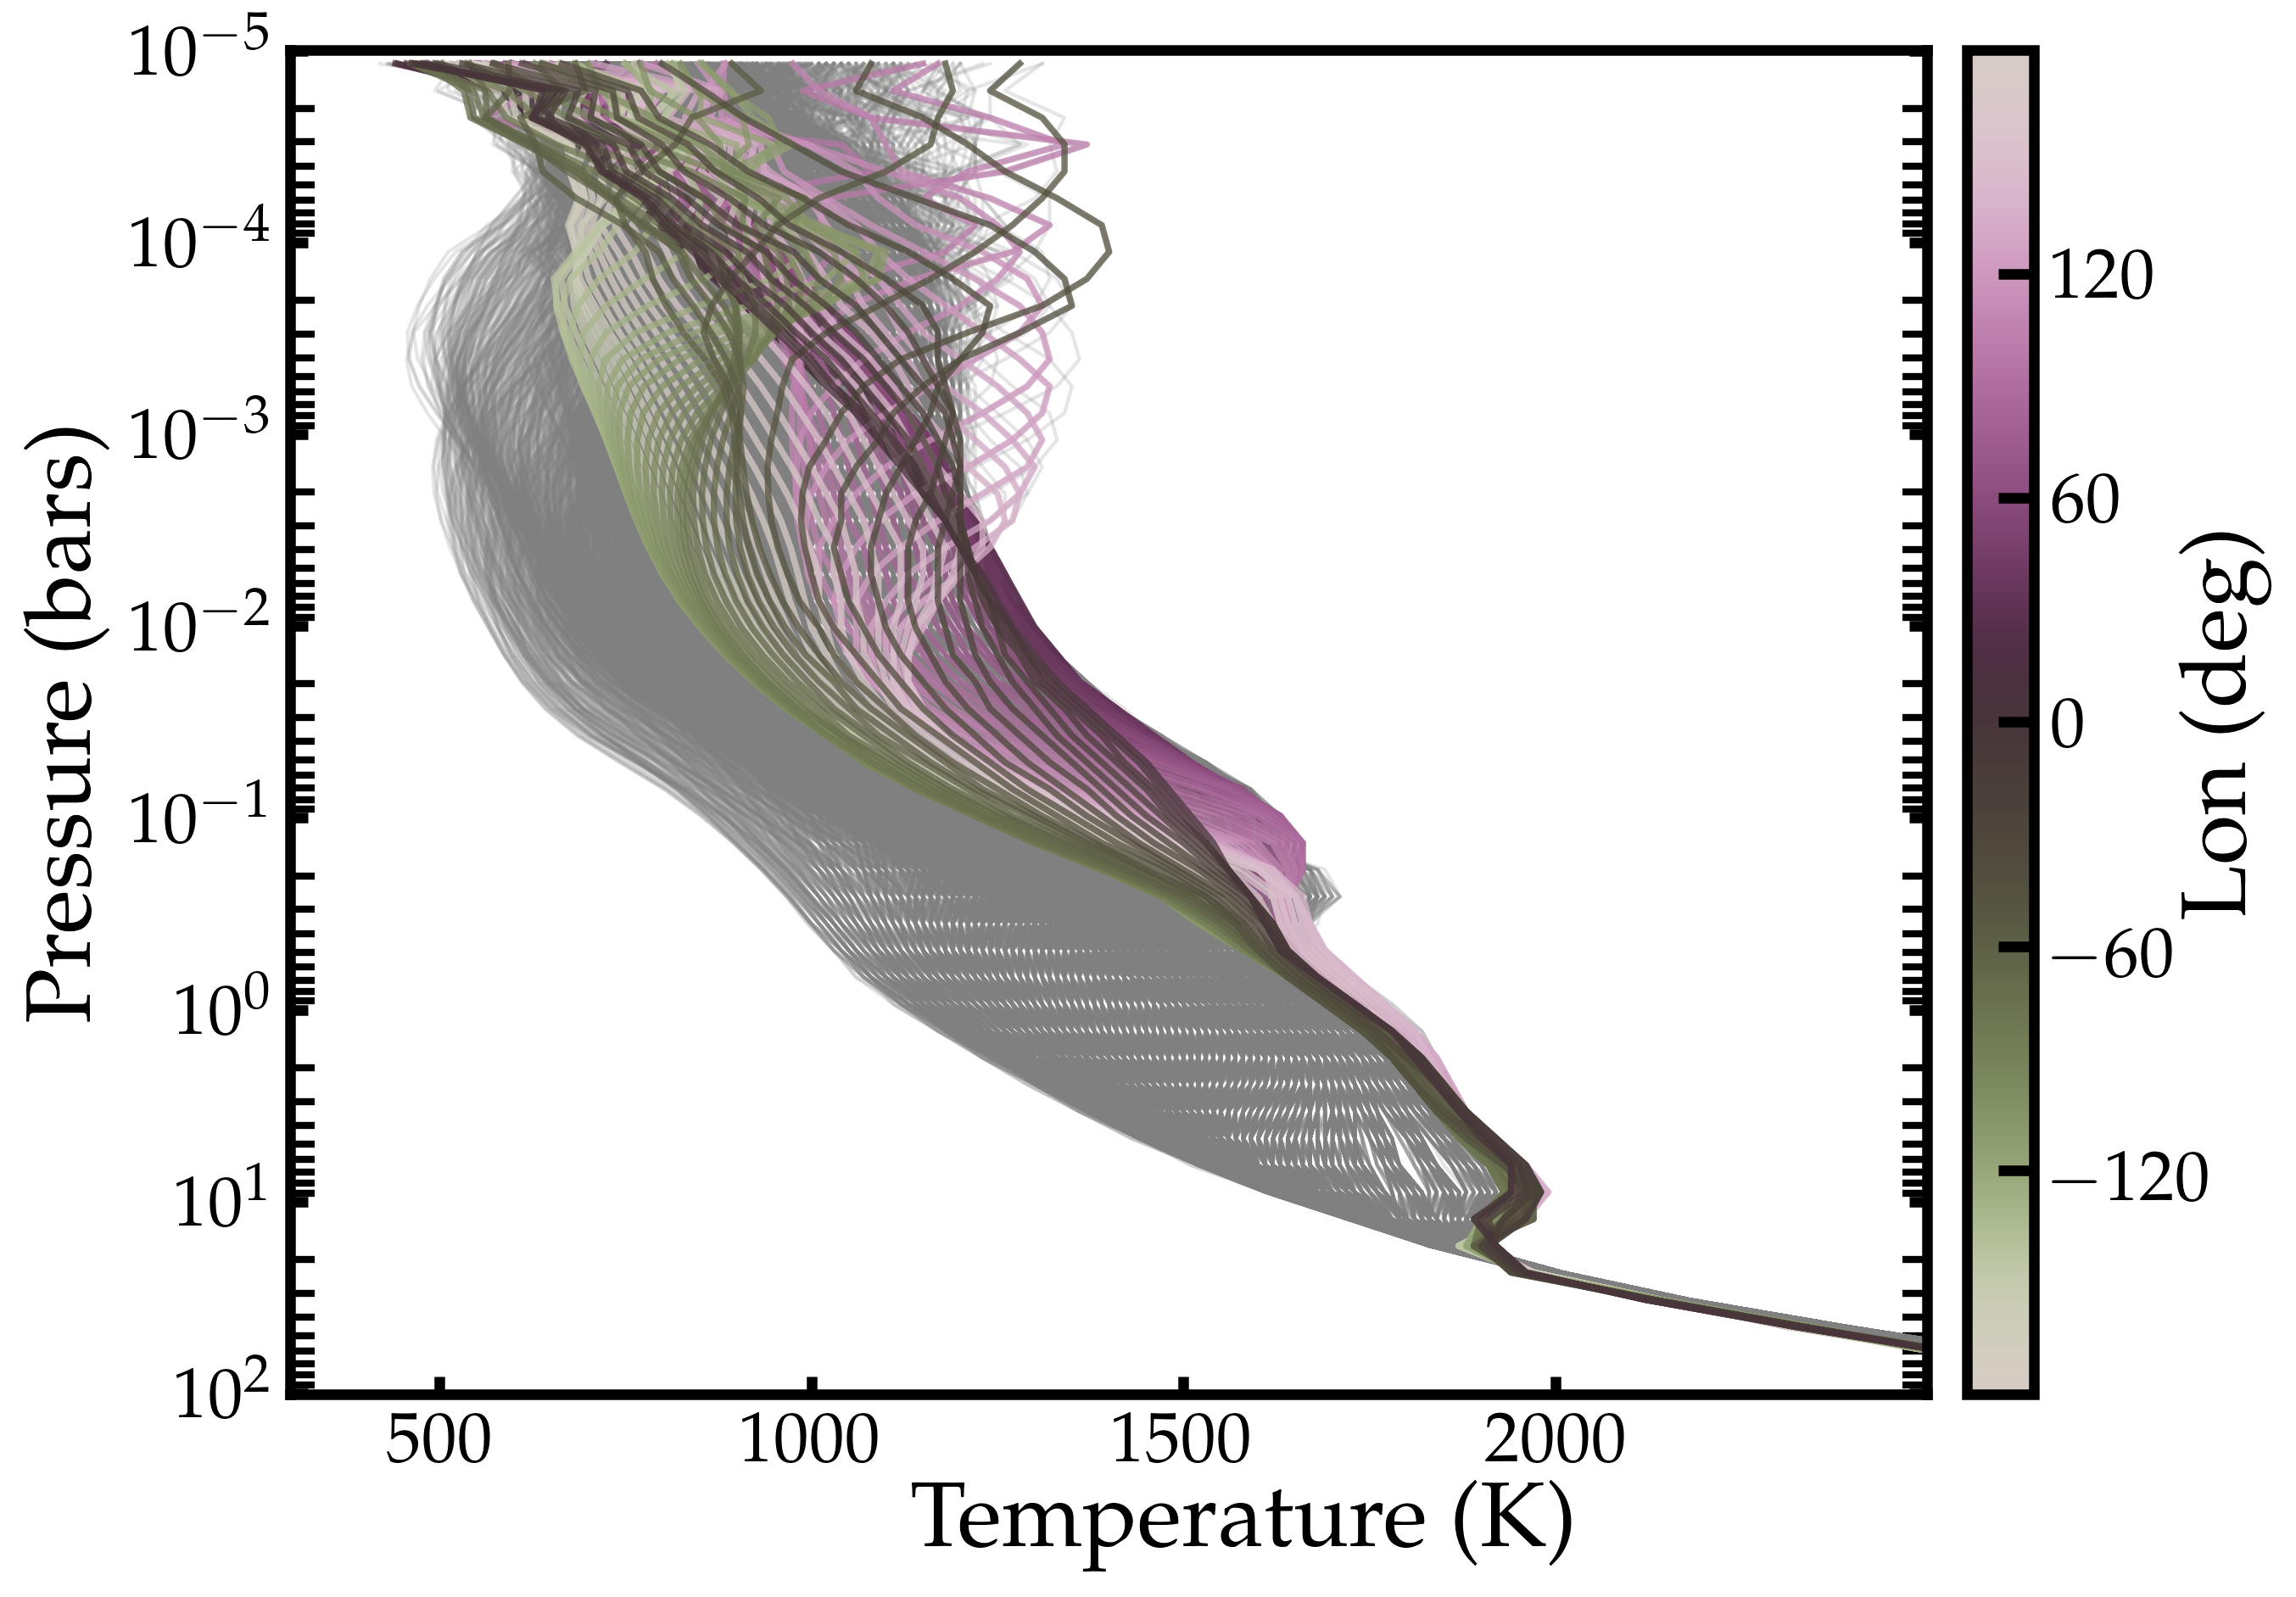

In [8]:
### ----- INPUT/OUTPUT CONTROL ----- ###

condensation_data = 'DATA/Condensation_Ts.dat'       # condensation curves

Tmin = 0
Tmax = 650

NLAT = 48
NLON = 193
NTAU = nlevel
NPARAMS = 9


for ind, planet_name in enumerate(planet_names):
    plt.clf()
    print('Creating plot for', planet_name)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
    plt.subplots_adjust(wspace=0.02, hspace=0.03)

    if 'CLOUDS' in planet_name:
        clouds = True
    else:
        clouds = False

    if 'NUC' in planet_name:
        nucleation = True
    else:
        nucleation = False
    
    
    data = np.loadtxt(base + planet_name + '_doubled.txt')
    data = data.reshape(NLAT, NLON, NTAU, NPARAMS)

    lons = data[:,:,0,1][0] - 360
    lats = data[:,:,0,0][:,0]
    
    delta_temps = np.zeros((NLAT, NLON))
    taus = np.zeros((NLAT, NLON))

    print('Calculating delta T and tau...')
    for i in range(NLAT):
        for j in range(NLON):
            max_dT = 0      # max temo inversion at this lat/lon
            current_dT = 0  # keep track of current continuous temp inversion

            for k in reversed(range(NTAU - 1)):

                # check if delta T is postive
                if data[i][j][k][5] > data[i][j][k + 1][5]:

                    # if delta T is positive, add it to the current continuous dT
                    dT = data[i][j][k][5] - data[i][j][k + 1][5]
                    current_dT += dT

                    # if the current dT is greater than the max dT, then it becomes the new max dT
                    if current_dT > max_dT:
                        max_dT = current_dT

                # if delta T is negative, reset the current continuous dT
                else:
                    current_dT = 0

            # save max dT to lat/lon grid
            delta_temps[i][j] = max_dT


    print (np.amax(delta_temps))
    print('Calculating delta T and tau DONE')


    # colormap
    cm_name = 'nuuk'
    cm_file = np.loadtxt(f'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
    my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)

    # add temperature map (must do twice to get rid of contour artifacts)
    #temp_map = axes[1].contourf(lons, lats, delta_temps, cmap=my_colors, levels=np.arange(Tmin, Tmax, 10))
    #temp_map = axes[1].contourf(lons, lats, delta_temps, cmap=my_colors,levels=np.arange(Tmin, Tmax, 10))

    
    """
    # format temp axes
    axes[1].set_xlim([-180, 180])
    axes[1].set_xticks([-100, 100])
    axes[1].spines['left'].set_position('zero')
    axes[1].spines['bottom'].set_position('zero')
    axes[1].spines['left'].set_color('none')
    axes[1].spines['right'].set_color('none')
    axes[1].spines['top'].set_color('none')
    axes[1].spines['bottom'].set_color('none')
    axes[1].tick_params(
        axis='both',
        which='both',
        top=False,
        bottom=False,
        right=False,
        left=False,
        labelcolor='w',
        labelsize=24,
        pad=-12)
    axes[1].grid(color='w',alpha=0.5,ls=':')
    axes[1].patch.set_edgecolor('black')  
    axes[1].patch.set_linewidth('2')  
    """



    ### tp profiles ###

    # adjust tick marks on both axes

    axes.tick_params(axis='both',
                  which='both',
                  direction='in',
                  top = True,
                  right = True)
    axes.tick_params(axis='both',
                  which='major',
                  length=5)


    # plot all TP-profiles (expensive)
    for i in range(48):
        for j in range(96):
            axes.semilogy(data[i][j][:,5], data[i][j][:,4], alpha=0.2, color='gray', linewidth=1)


    # colormap
    #cm_name = 'batlow'
    cm_name = 'bamO'
    cm_file = np.loadtxt(f'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
    cm_file  = np.roll(cm_file, 140, axis=0)
    my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)

    colors = np.linspace(0, 1, 96)
    # set color cycle
    color_idx = 48
    
    # plot colored equatorial TP-profiles
    for i in range(96):
        axes.semilogy(data[24][i][:,5], data[24][i][:,4],
                              '-', lw=1.8, alpha=0.75, color=my_colors(colors[color_idx]))

        color_idx += 1
        if (color_idx > 95):
            color_idx = color_idx - 96
    
    
    

    # plot cloud condensation curves
    if clouds == True:
        
        press_con, kcl, zns, na2s, mns, cr, sio2, mg2sio4, vo, ni, fe, ca2sio4, catio3, al2o3, mgsio3= np.loadtxt(condensation_data, unpack=True)
        # KCl, Cr, SiO2, Mg$_2$SiO$_4$, VO, Ni, Ca$_2$SiO$_4$, CaTiO$_3$, Al$_2$O$_3$
        
        new_pressures = np.logspace(-5, 2, 200)
        
        f_kcl = interp1d( press_con, kcl, fill_value='extrapolate')
        f_zns = interp1d(press_con, zns,  fill_value='extrapolate')
        f_na2s = interp1d(press_con,na2s,  fill_value='extrapolate')
        f_mns = interp1d(press_con, mns, fill_value='extrapolate')
        f_cr = interp1d(press_con,cr,  fill_value='extrapolate')
        f_sio2 = interp1d(press_con,sio2,  fill_value='extrapolate')
        f_mg2sio4 = interp1d(press_con,mg2sio4,  fill_value='extrapolate')
        f_vo = interp1d(press_con,vo,  fill_value='extrapolate')
        f_ni = interp1d(press_con,ni,  fill_value='extrapolate')
        f_fe = interp1d(press_con,fe,  fill_value='extrapolate')
        f_ca2sio4 = interp1d(press_con, ca2sio4,  fill_value='extrapolate')
        f_catio3 = interp1d(press_con,catio3,  fill_value='extrapolate')
        f_al2o3 = interp1d( press_con,al2o3, fill_value='extrapolate')
        
        
        colors = ["#800000", "#9A6324", "#808000", "#469990", "#000075", "#000000", "#6f828a", "#e50000", "#f58231", "#3cb44b", "#4363d8", "#911eb4", "#f032e6"]
        
        axes.semilogy(f_kcl(new_pressures), new_pressures, lw=2, label='KCl', color=colors[0], linestyle='dashed')
        axes.semilogy(f_cr(new_pressures), new_pressures, lw=2, label='Cr', color=colors[1], linestyle='dashed')
        axes.semilogy(f_sio2(new_pressures), new_pressures, lw=2, label=r'SiO$_2$', color=colors[2], linestyle='dashed')
        axes.semilogy(f_mg2sio4(new_pressures), new_pressures, lw=2, label=r'Mg$_2$SiO$_4$', color=colors[3], linestyle='dashed')
        axes.semilogy(f_vo(new_pressures), new_pressures, lw=2, label='VO', color=colors[4], linestyle='dashed')
        axes.semilogy(f_ca2sio4(new_pressures), new_pressures, lw=2, label=r'Ca$_2$SiO$_4$', color=colors[5], linestyle='dashed')
        axes.semilogy(f_catio3(new_pressures), new_pressures, lw=2, label=r'CaTiO$_3$', color=colors[6], linestyle='dashed')
        axes.semilogy(f_al2o3(new_pressures), new_pressures, lw=2, label=r'Al$_2$O$_3$', color=colors[7], linestyle='dashed')


        if nucleation == False:
            axes.semilogy(f_fe(new_pressures), new_pressures, lw=2, label=r'Fe', color=colors[8], linestyle='dashed')
            axes.semilogy(f_na2s(new_pressures), new_pressures, lw=2, label=r'Na$_2$S', color=colors[9], linestyle='dashed')
            axes.semilogy(f_mns(new_pressures), new_pressures, lw=2, label=r'MnS', color=colors[10], linestyle='dashed')
            axes.semilogy(f_zns(new_pressures), new_pressures, lw=2, label=r'ZnS', color=colors[11], linestyle='dashed')
            axes.semilogy(f_ni(new_pressures), new_pressures, lw=2, label=r'Ni', color=colors[12], linestyle='dashed')
            
        axes.legend(fontsize=16, ncol=2, labelspacing=0.0, loc='lower left')


    
    axes.set_ylim([0.99e-5, 1.01e+2])
    axes.set_xlim([300, 2499])
    #axes[0].set_xlim([350,1000])

    
    axes.invert_yaxis()
    axes.xaxis.set_ticks_position('bottom')
    axes.xaxis.set_label_position('bottom')
    
    
    # tp labels
    axes.set_ylabel('Pressure (bars)', fontsize=26)

    

    # colorbars
    sm = plt.cm.ScalarMappable(cmap=my_colors, norm=plt.Normalize(vmin=-180, vmax=180))
    sm._A = []
    #cax = fig.add_axes([0.92, 0.0, 0.025, 0.37])
    #tp_cbar = fig.colorbar(sm, cax=cax, ticks=[0, -60, -120, 60, 120])
    tp_cbar = fig.colorbar(sm, aspect=20, pad=0.02, ticks=[0, -60, -120, 60, 120])
    tp_cbar.set_label('Lon (deg)', fontsize=26, labelpad=-10)


    #temp_cbar = fig.colorbar(temp_map, ax=axes.ravel().tolist(), location='bottom', aspect=30, pad=0.02)
    #temp_cbar.set_label('Max. Temperature Inversion (K)')


    #temp_ax = fig.add_axes([0.92, 0.125, 0.025, 0.37])
    #tp_cbar = fig.colorbar(temp_map, cax=temp_ax)
    #tp_cbar.set_label('Max. Temperature Inversion (K)', fontsize=20, labelpad=5)


    fig.text(0.5, 0.04, r"Temperature (K)", size=26, ha='center')


    print('Creating plot DONE')

    fig.savefig('../Figures/PTC_Curves_{}.png'.format(planet_name), bbox_inches='tight', dpi=100)
